##### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2025 Semester 1

## Assignment 1: Scam detection with naive Bayes


**Student ID(s):**     `1455881`


This iPython notebook is a template which you will use for your Assignment 1 submission.

**NOTE: YOU SHOULD ADD YOUR RESULTS, GRAPHS, AND FIGURES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).** Results, figures, etc. which appear in this file but are NOT included in your report will not be marked.

**Adding proper comments to your code is MANDATORY. **

## 1. Supervised model training


In [248]:
import numpy as np
import pandas as pd


In [5]:
# read the input file
df = pd.read_csv("sms_supervised_train.csv")

print(df.head())

                                        textOriginal  \
0                       So u workin overtime nigpun?   
1  Also sir, i sent you an email about how to log...   
2  Ok lor. Anyway i thk we cant get tickets now c...   
3                                 Wat r u doing now?   
4  Is there a reason we've not spoken this year? ...   

                                    textPreprocessed  class  
0                                         ? u workin      0  
1  . . .. sir , send send email log payment ll an...      0  
2  ? . . 2 4 u quite get ok lor anyway thk ticket...      0  
3                                          ? u wat r      0  
4   ? great reason speak year anyways week good exam      0  


In [167]:
def create_vocabulary(data):
    words = " ".join(data['textPreprocessed'].fillna('').astype(str)).split()
    vocabulary, _ = np.unique(words, return_counts=True)
    vocabulary = list(vocabulary)
    return vocabulary

In [169]:
vocabulary = create_vocabulary(df)
len(vocabulary)

2006

In [381]:
def create_count(data, vocab):
    N = len(data)
    V = len(vocab)
    count= np.zeros((N, V), dtype=int)
    total = 0

    for i, text in enumerate(data['textPreprocessed'].fillna('').astype(str)):
        for word in text.split():
            if word in vocab:
                j = vocab.index(word)
                count[i, j] += 1
                total += 1
    
    return count

In [371]:
count = create_count(df, vocabulary)
count

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [173]:
count_df = pd.DataFrame(count, columns=vocabulary)
count_df

,!,"""",#,$,%,&,','ll,'m,'re,...,yup,zed,|,,¡,£,ü,–,…,�
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1998,0,0,1,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
# check class name is not existed in the vocabulary
print("class_label" in vocabulary)

False


In [309]:
# new dataframe with vocabulary frequency and class labels
count_df['class_label'] = df['class']
count_df

,!,"""",#,$,%,&,','ll,'m,'re,...,zed,|,,¡,£,ü,–,…,�,class_label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1998,0,0,1,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Probability of all the labels
def calc_prior(df):
    class_counts = df['class_label'].value_counts()
    N = len(df)
    priors = {}
    for c, count in class_counts.items():
        priors[c] = count / N
    return priors


In [351]:
def prop_word(data):
    # Create an empty dictionary to store the likelihoods
    word = {}
    labels = data['class_label']
    unique_labels = np.unique(labels)
    features_list = [col for col in vocabulary if col != 'class_label']
    total_sum = 0

    for feature in features_list:
        # feature_values = np.unique(data[feature])
        
        # Create a nested dictionary for each feature
        word[feature] = {}

        for label in unique_labels:
            # Create a nested dictionary for each label
            word[feature][label] = {}

            count = data[(data["class_label"] == label)][feature].sum()
            #print(count)
            total_count = data[data["class_label"] == label][features_list].sum(axis=1).sum()
            #print(total_count)
            total_count += 1*len(features_list)
            count += 1

            word[feature][label] = count / total_count
            total_sum += count / total_count
            print(f"Likelihood of {feature} given label {label} is {word[feature][label]:.4f}")
            # print(f"Likelihood of {feature}={value} given label {label} is {likelihood[feature][label][value]:.4f}")
    #print(total_sum)
    return word

In [ ]:
# the function to train original dataframe at once
def train_model(data):
    vocabulary = create_vocabulary(data)
    count_df = pd.DataFrame(create_count(data, vocabulary), columns=vocabulary)

    try:
        if "class_label" in vocabulary:
            raise ValueError("The column name 'class_label' is already in use in the vocabulary. Please use a different name for the class column.")
        count_df['class_label'] = df['class']
    except ValueError as e:
        print(e)


    # Calculate prior probabilities
    prior_prob = calc_prior(count_df)

    # Calculate likelihoods
    likelihood = prop_word(count_df)

    return prior_prob, likelihood, vocabulary

In [ ]:
# train the model
priors_prob, word_probs, vocabulary= train_model(df)

print("Priors:", priors_prob)
print("likelihood:", word_probs)

Likelihood of ! given label 0 is 0.0172
Likelihood of ! given label 1 is 0.0244
Likelihood of " given label 0 is 0.0056
Likelihood of " given label 1 is 0.0008
Likelihood of # given label 0 is 0.0054
Likelihood of # given label 1 is 0.0007
Likelihood of $ given label 0 is 0.0004
Likelihood of $ given label 1 is 0.0008
Likelihood of % given label 0 is 0.0002
Likelihood of % given label 1 is 0.0009
Likelihood of & given label 0 is 0.0131
Likelihood of & given label 1 is 0.0087
Likelihood of ' given label 0 is 0.0039
Likelihood of ' given label 1 is 0.0012
Likelihood of 'll given label 0 is 0.0006
Likelihood of 'll given label 1 is 0.0001
Likelihood of 'm given label 0 is 0.0001
Likelihood of 'm given label 1 is 0.0001
Likelihood of 're given label 0 is 0.0003
Likelihood of 're given label 1 is 0.0001
Likelihood of 's given label 0 is 0.0052
Likelihood of 's given label 1 is 0.0018
Likelihood of 've given label 0 is 0.0001
Likelihood of 've given label 1 is 0.0010
Likelihood of ( given la

In [115]:
def top_words_by_class(word_probs, top_n=10):
    class_words = {}

    # Initialize dictionary for each class
    for word, probs in word_probs.items():
        for label, prob in probs.items():
            if label not in class_words:
                class_words[label] = []
            class_words[label].append((word, prob))
    
    # Sort and print top N words for each class
    for label in sorted(class_words.keys()):
        print(f"\nTop {top_n} words for class {label}:")
        sorted_words = sorted(class_words[label], key=lambda x: x[1], reverse=True)
        for word, prob in sorted_words[:top_n]:
            print(f"{word}: {prob:.6f}")

In [322]:
top_words_by_class(word_probs, top_n=10)


Top 10 words for class 0:
.: 0.079330
,: 0.026033
?: 0.025585
u: 0.018923
...: 0.018755
!: 0.017187
..: 0.014948
;: 0.013156
&: 0.013100
go: 0.011141

Top 10 words for class 1:
.: 0.056528
!: 0.024350
,: 0.023481
call: 0.020546
£: 0.013915
free: 0.010545
/: 0.009131
2: 0.008805
&: 0.008697
?: 0.008479


In [212]:
def most_predictive_words(word_probs, pred_n=10):
    ratios = []

    for word, probs in word_probs.items():
        p0 = probs.get(0, 1e-10)  # Avoid division by zero
        p1 = probs.get(1, 1e-10)
        ratio = p1 / p0
        ratios.append((word, ratio))

    # Top predictors for class 1 (scam): Highest R values
    print(f"\nTop {pred_n} most predictive words for SCAM class (class 1):")
    top_scams = sorted(ratios, key=lambda x: x[1], reverse=True)[:pred_n]
    for word, r in top_scams:
        print(f"{word}: R = {r:.4f}")

    # Top predictors for class 0 (non-malicious): Lowest R values
    print(f"\nTop {pred_n} most predictive words for NON-MALICIOUS class (class 0):")
    top_non_malicious = sorted(ratios, key=lambda x: x[1])[:pred_n]
    for word, r in top_non_malicious:
        print(f"{word}: R = {r:.4f}")

In [319]:
most_predictive_words(word_probs, pred_n=10)


Top 10 most predictive words for SCAM class (class 1):
prize: R = 99.0284
tone: R = 64.0772
£: R = 49.7084
select: R = 46.6016
claim: R = 45.9543
paytm: R = 36.8929
code: R = 34.9512
award: R = 32.0386
won: R = 31.0677
18: R = 29.1260

Top 10 most predictive words for NON-MALICIOUS class (class 0):
;: R = 0.0165
...: R = 0.0174
gt: R = 0.0185
lt: R = 0.0187
:): R = 0.0209
ü: R = 0.0313
lor: R = 0.0347
hope: R = 0.0405
ok: R = 0.0405
d: R = 0.0474


In [405]:
import math
from math import factorial
from functools import reduce

def calc_posterior_with_smoothing(data, prior_prob, word_probs, alpha=1.0):
    posterior_probs = []
    classes = prior_prob.keys()

    for _, instance in data.iterrows():
        x_vector = instance.to_dict()
        n = sum(x_vector.values())  # total number of words in the row
 
        # Precompute factorials for multinomial coefficient
        # try:
        numerator = factorial(n)
        denominator = reduce(lambda a, b: a * b, [factorial(x) for x in x_vector.values() if x > 0], 1)
        #print(numerator)
        #print(denominator)
        multinomial_coeff = numerator / denominator
        # except OverflowError:
            # If n is too large, we can safely omit multinomial coefficient (constant across classes)
            # multinomial_coeff = 1.0

        post_probs = {}

        for label in classes:
            prob = prior_prob[label] * multinomial_coeff

            for word, x_i in x_vector.items():
                if x_i == 0:
                    continue

                # Get smoothed P(word | class)
                p_c_i = word_probs.get(word, {}).get(label, None)
                if p_c_i is None:
                    # If somehow missing, apply Laplace smoothing manually
                    V = len(word_probs)
                    p_c_i = alpha / (alpha * V)
                    # print the misssing value:
                    print("mission value with smoothing:", word)

                #print("word:", word)
                #print("pci:",p_c_i)
                prob *= p_c_i ** x_i

            post_probs[label] = prob

        # Normalize
        #total = sum(post_probs.values())
        #if total == 0:
            #norm_probs = {label: 1.0 / len(classes) for label in classes}
        #else:
            #norm_probs = {label: post_probs[label] / total for label in classes}

        posterior_probs.append(post_probs)

    return posterior_probs

In [ ]:
# posterior_prob testing 
#posterior_probs = calc_posterior_with_smoothing(test_count, priors_prob, word_probs)
#print(posterior_probs)

[{0: 1.4637702565119978e-18, 1: 2.876560889584209e-22}, {0: 7.866314316250244e-32, 1: 4.6646684957864e-38}, {0: 2.019023888300887e-23, 1: 1.7281624069306524e-27}, {0: 2.825383328346374e-16, 1: 9.297585137667671e-24}, {0: 1.373571688433441e-53, 1: 4.1844751050781e-46}, {0: 4.552553179855447e-36, 1: 3.0078868282115895e-49}, {0: 9.238009915728088e-09, 1: 1.5631380846775775e-09}, {0: 6.516113571106937e-19, 1: 4.073451609376241e-21}, {0: 4.5473207605034766e-27, 1: 2.525290428412555e-30}, {0: 1.7693148522459765e-23, 1: 1.184145471970185e-30}, {0: 6.768484187669109e-10, 1: 1.7428182937137287e-14}, {0: 4.823606870104947e-11, 1: 3.940713176350206e-13}, {0: 3.132630842449868e-19, 1: 2.4916321552674845e-24}, {0: 1.4962073760775374e-26, 1: 7.237609536953216e-21}, {0: 2.1390099518961945e-23, 1: 1.4848571724636457e-35}, {0: 6.946080402304054e-13, 1: 1.1797721586768634e-14}, {0: 4.0984778307615555e-64, 1: 6.695246264461386e-82}, {0: 4.34432408681032e-07, 1: 1.6032185483872591e-09}, {0: 1.617899698816

In [324]:
def predict_test_with_smoothing(data, prior_prob, likelihood):
    # Calculate posterior probabilities
    posterior_probs = calc_posterior_with_smoothing(data, prior_prob, likelihood)
    print(posterior_probs)

    # Find argmax for each instance
    argmax_labels = []
    for post_probs in posterior_probs:
        max_prob = 0
        max_label = None
        for label in post_probs:
            if label in prior_prob:
                prob = post_probs[label]
                if prob > max_prob:
                    max_prob = prob
                    max_label = label
        if max_label is not None:
            argmax_labels.append(max_label)
    return argmax_labels

## 2. Supervised model evaluation

In [260]:
test_df = pd.read_csv("sms_test.csv")

In [330]:
test_vocabulary = create_vocabulary(df)
len(test_vocabulary)

2006

In [331]:
test_count = pd.DataFrame(create_count(test_df, test_vocabulary), columns = test_vocabulary)
test_count

,!,"""",#,$,%,&,','ll,'m,'re,...,yup,zed,|,,¡,£,ü,–,…,�
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [406]:
predictions = predict_test_with_smoothing(test_count, priors_prob, word_probs)

[{0: 1.4637702565119978e-18, 1: 2.876560889584209e-22}, {0: 7.866314316250244e-32, 1: 4.6646684957864e-38}, {0: 2.019023888300887e-23, 1: 1.7281624069306524e-27}, {0: 2.825383328346374e-16, 1: 9.297585137667671e-24}, {0: 1.373571688433441e-53, 1: 4.1844751050781e-46}, {0: 4.552553179855447e-36, 1: 3.0078868282115895e-49}, {0: 9.238009915728088e-09, 1: 1.5631380846775775e-09}, {0: 6.516113571106937e-19, 1: 4.073451609376241e-21}, {0: 4.5473207605034766e-27, 1: 2.525290428412555e-30}, {0: 1.7693148522459765e-23, 1: 1.184145471970185e-30}, {0: 6.768484187669109e-10, 1: 1.7428182937137287e-14}, {0: 4.823606870104947e-11, 1: 3.940713176350206e-13}, {0: 3.132630842449868e-19, 1: 2.4916321552674845e-24}, {0: 1.4962073760775374e-26, 1: 7.237609536953216e-21}, {0: 2.1390099518961945e-23, 1: 1.4848571724636457e-35}, {0: 6.946080402304054e-13, 1: 1.1797721586768634e-14}, {0: 4.0984778307615555e-64, 1: 6.695246264461386e-82}, {0: 4.34432408681032e-07, 1: 1.6032185483872591e-09}, {0: 1.617899698816

In [233]:
def calc_accuracy(predictions, true_labels):
    correct = 0
    total = len(predictions)
    for i in range(total):
        if predictions[i] == true_labels[i]:
            correct += 1
    accuracy = correct / total
    print("correct predict: ", correct)
    print("total test: ", total)
    return accuracy

In [337]:
true_labels = test_df['class'].tolist()
accuracy = calc_accuracy(predictions, true_labels)
print("Accuracy:", accuracy)

correct predict:  975
total test:  1000
Accuracy: 0.975


In [294]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

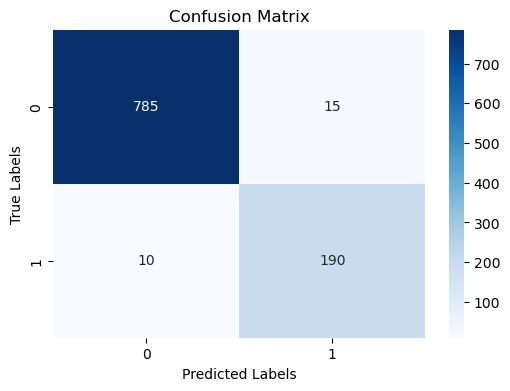


Classification Report:
              precision    recall  f1-score   support

           0     0.9874    0.9812    0.9843       800
           1     0.9268    0.9500    0.9383       200

    accuracy                         0.9750      1000
   macro avg     0.9571    0.9656    0.9613      1000
weighted avg     0.9753    0.9750    0.9751      1000



In [347]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, predictions, digits=4))

In [328]:
# out-of-vocabulary words in the test set
def new_vocab(vocab1, vocab2):
    new_words = set(vocab1) - set(vocab2)
    if new_words:
        print("New words not in training vocabulary:")
        print(new_words)
        print("Number of new words:")
        print(len(new_words))
    else:
        print("All test vocabulary words are present in the training vocabulary.")


In [329]:
new_vocab(test_vocabulary, vocabulary)

All test vocabulary words are present in the training vocabulary.


## 3. Extending the model with semi-supervised training

##### Read unlabelled csv file

In [380]:
unlabel_df = pd.read_csv("sms_unlabelled.csv")
unlabel_vocabulary = create_vocabulary(unlabel_df)
len(unlabel_vocabulary)

1983

In [373]:
new_vocab(unlabel_vocabulary, vocabulary)

New words not in training vocabulary:
{'brain', 'should', 'fee', 'basic', 'nearly', '81151', 'harry', '08081560665', 'plot', 'fetch', '1956669', 'realise', 'perfect', 'k.', 'manage', '88039', 'lift', 'scared', 'affair', 'fire', 'calling', 'wed', 'callfreefone', 'law', 'sha', 'report', 'piece', '=d', 'exactly', 'wet', 'challenge', '://', 'bloody', 'activity', 'girlfrnd', 'insurance', 'skip', 'esplanade', 'ta', 'sen', 'legal', 'nvm', '0845', 'body', 'hook', '2nite', '5min', 'pie', 'agree', 'definitely', 'mini', 'ec2a', 'require', 'empty', 'stick', 'inside', 'ma', 'nichols', 'experience', 'trouble', 'journey', 'yahoo', 'bet', 'daddy', 'cruise', 'armand', 'fromm', 'skype', 'fyi', 'lecture', 't-mobile', 'bud', 'pack', 'annoying', 'yijue', 'title', 'cancer', 'helpline', 'sura', 'prabha', 'greet', 'proof', 'lmao', 'bahamas', 'sup', 'holla', 'peace', 'é', 'realy', 'taunton', 'august', 'dick', 'pg', 'hmv', 'feelin', 'postcode', '87131', 'ru', 'gram', '7250i', 'santa', 'boston', 'asleep', 'pull'

##### Baseline model using ramdom sampling for the 200 instances

In [286]:
# option 2
# baseline: random sampling 

def random_sample_and_merge(train_data, unlabelled_data, sample_size=200, label_col="class", random_state=None):
    # Randomly sample from unlabelled data
    sampled = unlabelled_data.sample(n=sample_size, random_state=random_state)
    
    # Extract labels
    # sampled_labels = sampled[label_col]
    # train_labels = train_data[label_col]
    
    # Drop label column from both dataframes to get feature-only data
    #sampled_features = sampled.drop(columns=[label_col])
    #train_features = train_data.drop(columns=[label_col])
    
    # Combine features and labels
    updated_data = pd.concat([train_data, sampled], axis=0)
    #updated_labels = pd.concat([train_labels, sampled_labels], axis=0)

    return updated_data #, updated_labels

In [360]:
baseline_train_data = random_sample_and_merge(
    df,
    unlabel_df,
    sample_size=200,
    random_state=42
)

baseline_train_data

,textOriginal,textPreprocessed,class
0,So u workin overtime nigpun?,? u workin,0
1,"Also sir, i sent you an email about how to log...",". . .. sir , send send email log payment ll an...",0
2,Ok lor. Anyway i thk we cant get tickets now c...,? . . 2 4 u quite get ok lor anyway thk ticket...,0
3,Wat r u doing now?,? u wat r,0
4,Is there a reason we've not spoken this year? ...,? great reason speak year anyways week good exam,0
...,...,...,...
462,Play w computer? Aiyah i tok 2 u lor?,? ? 2 u lor computer aiyah play w,0
1105,Todays Vodafone numbers ending 7148 are select...,. please call award apply end rs. vodafone tod...,1
855,"chile, please! It's only a &lt;DECIMAL&gt; h...",". . come , please ! time & & ; ; hour lt gt dr...",0
693,Send me your id and password,send id password,0


In [361]:
semi_vocabulary = create_vocabulary(baseline_train_data)
len(semi_vocabulary)

2035

In [362]:
semi_count = pd.DataFrame(create_count(baseline_train_data, semi_vocabulary), columns = semi_vocabulary)
semi_count

,!,"""",#,$,%,&,','ll,'m,'re,...,yup,zed,|,,¡,£,ü,–,…,�
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2197,1,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# train the new semi-supervised model
base_priors_prob, base_word_probs, base_vocabulary = train_model(baseline_train_data)

print("Baseline Priors:", base_priors_prob)
print("Baseline likelihood:", base_word_probs)

Likelihood of ! given label 0.0 is 0.0173
Likelihood of ! given label 1.0 is 0.0246
Likelihood of ! given label nan is 0.0005
Likelihood of " given label 0.0 is 0.0056
Likelihood of " given label 1.0 is 0.0008
Likelihood of " given label nan is 0.0005
Likelihood of # given label 0.0 is 0.0054
Likelihood of # given label 1.0 is 0.0007
Likelihood of # given label nan is 0.0005
Likelihood of $ given label 0.0 is 0.0005
Likelihood of $ given label 1.0 is 0.0008
Likelihood of $ given label nan is 0.0005
Likelihood of % given label 0.0 is 0.0002
Likelihood of % given label 1.0 is 0.0009
Likelihood of % given label nan is 0.0005
Likelihood of & given label 0.0 is 0.0132
Likelihood of & given label 1.0 is 0.0088
Likelihood of & given label nan is 0.0005
Likelihood of ' given label 0.0 is 0.0039
Likelihood of ' given label 1.0 is 0.0012
Likelihood of ' given label nan is 0.0005
Likelihood of 'll given label 0.0 is 0.0006
Likelihood of 'll given label 1.0 is 0.0001
Likelihood of 'll given label 

##### Second Strategy: Uncertainty Sampling, Pick high-entropy samples

In [384]:
# entropy computation
def compute_entropy_scores(unlabelled_data, posterior_function, prior, likelihood):
    
    posterior_probs = posterior_function(unlabelled_data, prior, likelihood)

    entropy_values = []
    for probs in posterior_probs:
        entropy = -sum(p * np.log2(p) for p in probs.values() if p > 0)
        entropy_values.append(entropy)

    return pd.Series(entropy_values, index=unlabelled_data.index)

In [369]:
def select_high_entropy_samples(unlabelled_data, entropy_scores, k=200):
    top_k_indices = entropy_scores.sort_values(ascending=False).head(k).index
    selected_df = unlabelled_data.loc[top_k_indices]
    return selected_df

In [385]:
entropy_count = pd.DataFrame(create_count(unlabel_df, unlabel_vocabulary), columns = unlabel_vocabulary)

# Step 1: Compute entropy
entropy_scores = compute_entropy_scores(entropy_count, calc_posterior_with_smoothing, priors_prob, word_probs)

# Step 2: Select top-k high-entropy samples
selected = select_high_entropy_samples(entropy_count, entropy_scores, k=200)

In [388]:
def merge_selected_with_labeled_data(
    original_text_data, original_train_data,
    selected_features, label_column='class'
):
    # Step 1: Extract matching rows from original_text_data
    selected_text = original_text_data.loc[selected_features.index, ['textOriginal', 'textPreprocessed', label_column]]

    # Step 2: Extract labels
    # selected_labels = selected_text[label_column]
    # selected_features_cleaned = selected_features.copy()

    # Step 3: Drop label column from text data and reset index
    # selected_text_cleaned = selected_text.drop(columns=[label_column])

    # Step 4: Combine with original training data
    #merged_features = pd.concat([original_train_data.drop(columns=[label_column]), selected_features_cleaned])
    #merged_labels = pd.concat([original_train_data[label_column], selected_labels])
    merged_text = pd.concat([
        original_train_data[['textOriginal', 'textPreprocessed']],
        selected_text
    ])

    return merged_text.reset_index(drop=True)

In [391]:
entropy_train_data = merge_selected_with_labeled_data(
    original_text_data=unlabel_df,
    original_train_data=df,
    selected_features=selected
)

entropy_train_data

,textOriginal,textPreprocessed,class
0,So u workin overtime nigpun?,? u workin,NaN
1,"Also sir, i sent you an email about how to log...",". . .. sir , send send email log payment ll an...",NaN
2,Ok lor. Anyway i thk we cant get tickets now c...,? . . 2 4 u quite get ok lor anyway thk ticket...,NaN
3,Wat r u doing now?,? u wat r,NaN
4,Is there a reason we've not spoken this year? ...,? great reason speak year anyways week good exam,NaN
...,...,...,...
2195,Dear i am not denying your words please,please dear word,0.0
2196,We have all rounder:)so not required:),:) :) require,0.0
2197,You need to get up. Now.,.. up get need,0.0
2198,I'm meeting Darren...,darren ... meeting,0.0


In [392]:
# train the new semi-supervised model
entropy_priors_prob, entropy_word_probs, entropy_vocabulary = train_model(entropy_train_data)

print("Baseline Priors:", entropy_priors_prob)
print("Baseline likelihood:", entropy_word_probs)

Likelihood of ! given label 0.0 is 0.0172
Likelihood of ! given label 1.0 is 0.0244
Likelihood of ! given label nan is 0.0005
Likelihood of " given label 0.0 is 0.0056
Likelihood of " given label 1.0 is 0.0008
Likelihood of " given label nan is 0.0005
Likelihood of # given label 0.0 is 0.0054
Likelihood of # given label 1.0 is 0.0007
Likelihood of # given label nan is 0.0005
Likelihood of $ given label 0.0 is 0.0004
Likelihood of $ given label 1.0 is 0.0008
Likelihood of $ given label nan is 0.0005
Likelihood of % given label 0.0 is 0.0002
Likelihood of % given label 1.0 is 0.0009
Likelihood of % given label nan is 0.0005
Likelihood of & given label 0.0 is 0.0131
Likelihood of & given label 1.0 is 0.0087
Likelihood of & given label nan is 0.0005
Likelihood of ' given label 0.0 is 0.0039
Likelihood of ' given label 1.0 is 0.0012
Likelihood of ' given label nan is 0.0005
Likelihood of 'll given label 0.0 is 0.0006
Likelihood of 'll given label 1.0 is 0.0001
Likelihood of 'll given label 

## 4. Supervised model evaluation

In [364]:
# baseline testing
base_predictions = predict_test_with_smoothing(test_count, base_priors_prob, base_word_probs)

[{0.0: 4.843840514668382e-30, 1.0: 5.753234285939759e-30}, {0.0: 1.2174783737998357e-41, 1.0: 6.639675911046766e-41}, {0.0: 2.487555397180792e-24, 1.0: 1.723208733324677e-27}, {0.0: 8.965500120507323e-27, 1.0: 3.785192165457829e-27}, {0.0: 2.6646308390703882e-64, 1.0: 8.302536747126467e-64}, {0.0: 1.609229648817222e-41, 1.0: 8.368348929307463e-46}, {0.0: 5.172580564770544e-11, 1.0: 4.335807229904331e-11}, {0.0: 6.355567360928946e-23, 1.0: 4.187397221978964e-25}, {0.0: 7.285939190165008e-35, 1.0: 2.493653938238323e-33}, {0.0: 9.298234037254469e-35, 1.0: 1.8004908446890678e-36}, {0.0: 6.044812149306133e-12, 1.0: 2.1460777502583403e-13}, {0.0: 4.207836262434291e-12, 1.0: 4.7140642509793294e-14}, {0.0: 6.670810556424207e-26, 1.0: 1.0500803218697251e-27}, {0.0: 5.674177770493657e-28, 1.0: 4.239415225312768e-27}, {0.0: 1.1102345803029503e-33, 1.0: 4.603508631659092e-39}, {0.0: 4.786953359033141e-19, 1.0: 7.168770879704972e-18}, {0.0: 1.1535963678572238e-88, 1.0: 2.1868025970226574e-91}, {0.0

In [365]:
true_labels = test_df['class'].tolist()
accuracy = calc_accuracy(base_predictions, true_labels)
print("Accuracy:", accuracy)

correct predict:  749
total test:  1000
Accuracy: 0.749


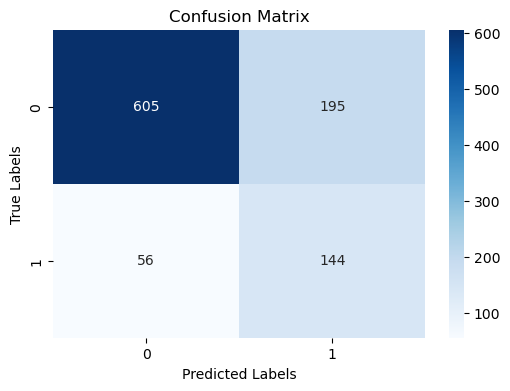


Classification Report:
              precision    recall  f1-score   support

           0     0.9153    0.7562    0.8282       800
           1     0.4248    0.7200    0.5343       200

    accuracy                         0.7490      1000
   macro avg     0.6700    0.7381    0.6813      1000
weighted avg     0.8172    0.7490    0.7694      1000



In [366]:
# Confusion Matrix
cm = confusion_matrix(true_labels, base_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, base_predictions, digits=4))

In [350]:
new_vocab(test_vocabulary, base_vocabulary)

All test vocabulary words are present in the training vocabulary.


In [393]:
# entropy testing
entropy_predictions = predict_test_with_smoothing(test_count, entropy_priors_prob, entropy_word_probs)


[{0.0: 1.330700233192725e-18, 1.0: 2.6150553541674633e-22}, {0.0: 7.151194832954766e-32, 1.0: 4.2406077234421833e-38}, {0.0: 1.8354762620917154e-23, 1.0: 1.5710567335733203e-27}, {0.0: 2.568530298496704e-16, 1.0: 8.45235012515243e-24}, {0.0: 1.248701534939492e-53, 1.0: 3.804068277343728e-46}, {0.0: 4.1386847089594967e-36, 1.0: 2.734442571101444e-49}, {0.0: 8.398190832480077e-09, 1.0: 1.421034622434161e-09}, {0.0: 5.923739610097216e-19, 1.0: 3.703137826705674e-21}, {0.0: 4.1339279640940685e-27, 1.0: 2.2957185712841407e-30}, {0.0: 1.6084680474963422e-23, 1.0: 1.0764958836092592e-30}, {0.0: 6.153167443335552e-10, 1.0: 1.5843802670124804e-14}, {0.0: 4.3850971546408604e-11, 1.0: 3.5824665239547335e-13}, {0.0: 2.847846220408972e-19, 1.0: 2.265120141152259e-24}, {0.0: 1.3601885237068527e-26, 1.0: 6.579645033593831e-21}, {0.0: 1.9445545017238133e-23, 1.0: 1.3498701567851325e-35}, {0.0: 6.314618547549139e-13, 1.0: 1.0725201442516943e-14}, {0.0: 3.72588893705596e-64, 1.0: 6.086587513146713e-82},

In [394]:
true_labels = test_df['class'].tolist()
accuracy = calc_accuracy(entropy_predictions, true_labels)
print("Accuracy:", accuracy)

correct predict:  975
total test:  1000
Accuracy: 0.975


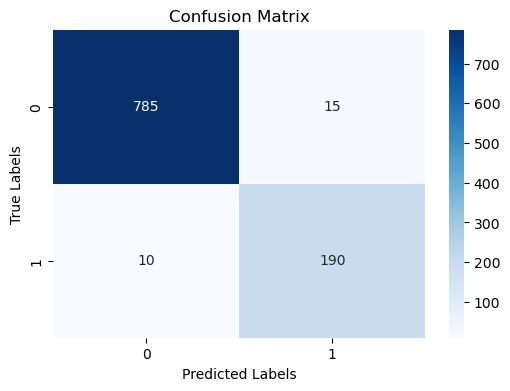


Classification Report:
              precision    recall  f1-score   support

           0     0.9874    0.9812    0.9843       800
           1     0.9268    0.9500    0.9383       200

    accuracy                         0.9750      1000
   macro avg     0.9571    0.9656    0.9613      1000
weighted avg     0.9753    0.9750    0.9751      1000



In [395]:
# Confusion Matrix
cm = confusion_matrix(true_labels, entropy_predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Precision, Recall, F1-Score
print("\nClassification Report:")
print(classification_report(true_labels, entropy_predictions, digits=4))

In [ ]:
### draft


In [401]:
all_data = pd.concat([df, unlabel_df], axis=0)
all_data

,textOriginal,textPreprocessed,class
0,So u workin overtime nigpun?,? u workin,0
1,"Also sir, i sent you an email about how to log...",". . .. sir , send send email log payment ll an...",0
2,Ok lor. Anyway i thk we cant get tickets now c...,? . . 2 4 u quite get ok lor anyway thk ticket...,0
3,Wat r u doing now?,? u wat r,0
4,Is there a reason we've not spoken this year? ...,? great reason speak year anyways week good exam,0
...,...,...,...
1995,Kay... Since we are out already,already ...,0
1996,call now 08707509020 Just 20p per min NTT Ltd...,", call call just rate national per 0870 min 08...",1
1997,Are you angry with me. What happen dear,. angry dear happen,0
1998,We r outside already.,. already r outside,0


In [397]:
# train all
all_priors_prob, all_word_probs, all_vocabulary = train_model(all_data)

print("Baseline Priors:", all_priors_prob)
print("Baseline likelihood:", all_word_probs)

Likelihood of ! given label 0.0 is 0.0172
Likelihood of ! given label 1.0 is 0.0244
Likelihood of ! given label nan is 0.0005
Likelihood of " given label 0.0 is 0.0056
Likelihood of " given label 1.0 is 0.0008
Likelihood of " given label nan is 0.0005
Likelihood of # given label 0.0 is 0.0054
Likelihood of # given label 1.0 is 0.0007
Likelihood of # given label nan is 0.0005
Likelihood of $ given label 0.0 is 0.0004
Likelihood of $ given label 1.0 is 0.0008
Likelihood of $ given label nan is 0.0005
Likelihood of % given label 0.0 is 0.0002
Likelihood of % given label 1.0 is 0.0009
Likelihood of % given label nan is 0.0005
Likelihood of & given label 0.0 is 0.0131
Likelihood of & given label 1.0 is 0.0087
Likelihood of & given label nan is 0.0005
Likelihood of ' given label 0.0 is 0.0039
Likelihood of ' given label 1.0 is 0.0012
Likelihood of ' given label nan is 0.0005
Likelihood of 'll given label 0.0 is 0.0006
Likelihood of 'll given label 1.0 is 0.0001
Likelihood of 'll given label 

In [398]:
all_predictions = predict_test_with_smoothing(test_count, all_priors_prob, all_word_probs)

[{0.0: 7.318851282559989e-19, 1.0: 1.4382804447921046e-22}, {0.0: 3.933157158125122e-32, 1.0: 2.3323342478932e-38}, {0.0: 1.0095119441504435e-23, 1.0: 8.640812034653262e-28}, {0.0: 1.412691664173187e-16, 1.0: 4.6487925688338354e-24}, {0.0: 6.867858442167205e-54, 1.0: 2.09223755253905e-46}, {0.0: 2.2762765899277234e-36, 1.0: 1.5039434141057948e-49}, {0.0: 4.619004957864044e-09, 1.0: 7.815690423387887e-10}, {0.0: 3.2580567855534684e-19, 1.0: 2.0367258046881206e-21}, {0.0: 2.2736603802517383e-27, 1.0: 1.2626452142062775e-30}, {0.0: 8.846574261229883e-24, 1.0: 5.920727359850925e-31}, {0.0: 3.3842420938345544e-10, 1.0: 8.714091468568644e-15}, {0.0: 2.4118034350524734e-11, 1.0: 1.970356588175103e-13}, {0.0: 1.566315421224934e-19, 1.0: 1.2458160776337422e-24}, {0.0: 7.481036880387687e-27, 1.0: 3.618804768476608e-21}, {0.0: 1.0695049759480973e-23, 1.0: 7.424285862318229e-36}, {0.0: 3.473040201152027e-13, 1.0: 5.898860793384317e-15}, {0.0: 2.0492389153807778e-64, 1.0: 3.347623132230693e-82}, {0

In [399]:
true_labels = test_df['class'].tolist()
accuracy = calc_accuracy(all_predictions, true_labels)
print("Accuracy:", accuracy)

correct predict:  975
total test:  1000
Accuracy: 0.975
